# Version information

In [10]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 08, 2021
Pyleecan version:1.3.1
SciDataTool version:1.4.1


# How to define a Parameter Sweep of a Variable speed simulation?
This tutorial explains how to use the object VarParam and VarLoadCurrent to run Parameter Sweep of a Variable speed simulation by using the multi-simulation tools of pyleecan. This tutorial combines several advanced aspect of pyleecan, please read the following tutorials first:

- "[How to define a machine](https://pyleecan.org/tuto_Machine.html)"
- "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)".
- "[How to set the Operating Point](https://pyleecan.org/tuto_Operating_point.html)".
- "[How to run a multi-simulation](https://pyleecan.org/tuto_multisimulation.html)".

The multi-simulation tools of Pyleecan can be combined to create multi-simulation of multi-simulation. This tutorial will build step by step (or layer by layer) a parameter sweep to study the impact of the stator slot opening of the Toyota Prius on the variable speed torque. 

## Machine and Reference Simulation definition
The first step is to define the reference simulation aka the original machine without any modifications from the VarParam (Parameter sweep object) nor the VarLoadCurrent (Variable speed object). This tutorial uses the usual machine Toyota_Prius (2004) and simulation from the previous tutorials:

<IPython.core.display.Javascript object>


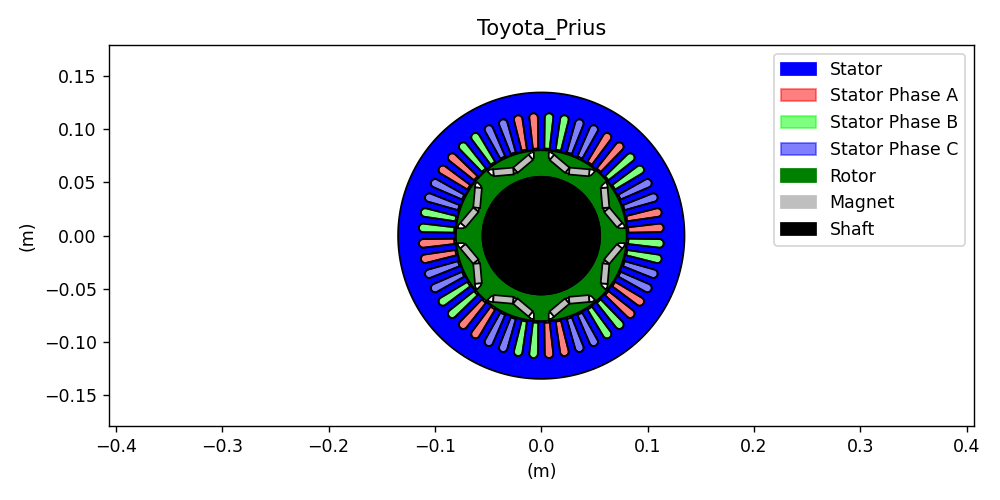

In [11]:
%matplotlib notebook

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

In [12]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from numpy import sqrt, pi
# Initialization of the Simulation
simu_ref = Simu1(name="tuto_multi", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None
# Set reference simulation operating point
simu_ref.input = InputCurrent()
simu_ref.input.set_Id_Iq(I0=250/sqrt(2), Phi0=140*pi/180)
simu_ref.input.Nt_tot = 128 # Number of time step
simu_ref.input.Na_tot = 2048 # Spatial discretization
simu_ref.input.N0 = 2000 # Rotor speed [rpm]

The reference simulation is fully defined and can be run before the multi-simulation to makes sure that everything is correctly defined. The multi-simulation will copy/update the reference simulation and its results will be available as a reference for comparison so the correct and optimized defintion of this simulation is essential.

The torque of the reference simulation is the following:

[00:11:46] Starting running simulation tuto_multi (machine=Toyota_Prius)
[00:11:46] Starting Magnetic module
[00:11:47] Solving time step 9 / 16 in FEMM
[00:11:47] Solving time step 13 / 16 in FEMM
[00:11:48] Solving time step 1 / 16 in FEMM
[00:11:48] Solving time step 5 / 16 in FEMM
[00:11:50] Solving time step 10 / 16 in FEMM
[00:11:50] Solving time step 14 / 16 in FEMM
[00:11:50] Solving time step 2 / 16 in FEMM
[00:11:50] Solving time step 6 / 16 in FEMM
[00:11:52] Solving time step 11 / 16 in FEMM
[00:11:52] Solving time step 15 / 16 in FEMM
[00:11:52] Solving time step 3 / 16 in FEMM
[00:11:53] Solving time step 7 / 16 in FEMM
[00:11:55] Solving time step 12 / 16 in FEMM
[00:11:55] Solving time step 16 / 16 in FEMM
[00:11:55] Solving time step 8 / 16 in FEMM
[00:11:55] Solving time step 4 / 16 in FEMM
[00:11:58] End of simulation tuto_multi


<IPython.core.display.Javascript object>


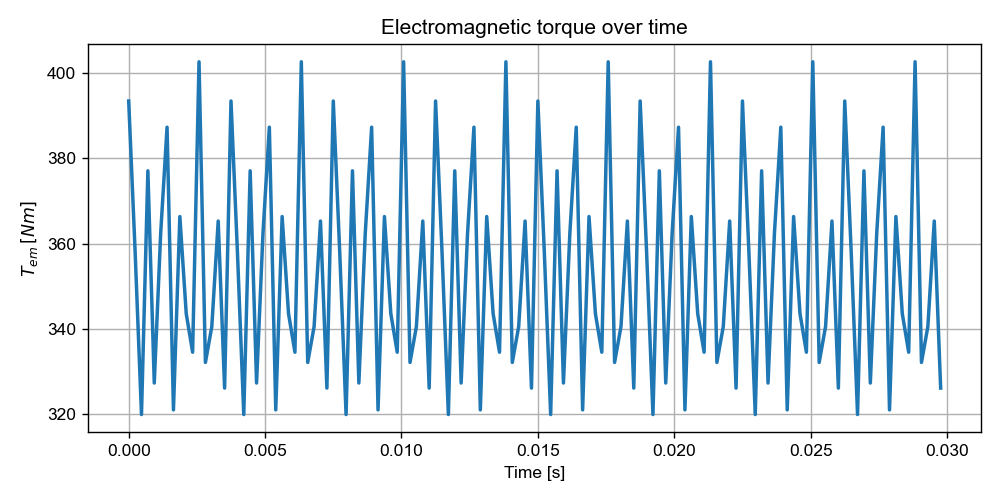

In [13]:
output_ref = simu_multi.run()
output_ref.mag.Tem.plot_2D_Data("time")

## First multi-simulation layer: Variable speed

The next step is to define the variable speed simulation. This tutorial uses the results from: 
Z. Yang, M. Krishnamurthy and I. P. Brown, “Electromagnetic and vibrational characteristic of IPM over full torque-speed range,” 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating points two steps are needed: First define a simulation that run correctly on a single operating point (like the one defined above), then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix with each line corresponding to an operating point and the column are:
- (N0, I0, Phi0) if type_OP_matrix==0
- (N0, Id, Iq) if type_OP_matrix==1

The following VarLoadCurrent object will run the previous simulation N_simu times by changing the value of Phi0. 

A fourth column can be added by setting is_torque=True. It enables to define the reference torque for the Operating Point. The reference is stored in output.elec.Tem_av_ref, the real computed torque is stored in output.mag.Tem_av.

Reference torque and current angle vector are:

In [14]:
from numpy import linspace, array, pi

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_speed = Tem_av_ref.size

In [15]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_speed,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_speed))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


This first layer will behave as follow:
- First the reference simulation will be run to get the reference output
- The reference simulation will be duplicated N_speed times with the value of InputCurrent updated according to the matrix. 
- is_reuse_femm will update the N_speed simulations to reuse the FEMM file drawn in the reference simulation to speed-up the computations.
- Each simulation of the list will be run separatly and the results gathered in an XOutput object

Pyleecan can detect that a simulation from the list matches the reference one and skip its computation to avoid computing twice the same thing. When defining a multi-simulation of multi-simulation, this optimization is essential since pyleecan will run "1 + (N_speed-1)" simulations instead of "1 + N_speed" for each combinaison of the design parameters.

In [ ]:
simu_vop = simu_op.copy()
simu_vop.var_simu = varload

# Speed-up computation (set reference simu as first OP)
simu_vop.input.set_OP_from_array(varload.OP_matrix, varload.type_OP_matrix)

Xout = simu_vop.run()

Pyleecan will automatically extract some values from each simulation. These values are all gathered in the xoutput_dict:

In [ ]:
print("Values available in XOutput:")
print(Xout.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout["Phi0"].result)

Any parameter in the XOutput can be plot as a function of any other

In [ ]:
fig = Xout.plot_multi("Phi0", "Tem_av")
fig = Xout.plot_multi("Id", "Iq")

Finally, the computed average torque can be compared to the one in the publication from Yang et al (data has been extracted from their graph using [Engauge Digitizer](http://markummitchell.github.io/engauge-digitizer/). Note that the generic plot function `plot_2D` has been used here.

In [ ]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from pyleecan.definitions import config_dict
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av"].result, Xout.xoutput_dict["Tem_av_ref"].result],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
    **dict_2D
)